In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option("display.max_columns", 100) 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression


In [408]:
def binary(df, df_index):
    decileScores = []
    for x in range(0, len(df["DecileScore"])):
        if df["DecileScore"][3*x+df_index] >= 1 and df["DecileScore"][3*x+df_index] <= 5:
            decileScores.append("Low")
        elif df["DecileScore"][3*x+df_index] >= 6 and df["DecileScore"][3*x+df_index] <= 10:
            decileScores.append("High")
        else:
            decileScores.append("NA")
    df["binaryScore"] = decileScores

def findSlash(sdate):
    slashes = []
    for x in range(0, len(sdate)):
        if sdate[x] == "/" or sdate[x] == " ":
            slashes.append(x)
    return slashes

def age(dob, sdate):
    #True = 1, False = 0
    byear = int(dob[6:])
    bmonth = int(dob[3:5])
    bday = int(dob[:2])
    
    slashes = findSlash(sdate)
    syear = int(sdate[slashes[1]+1:slashes[2]])
    smonth = int(sdate[slashes[0]+1:slashes[1]])
    sday = int(sdate[:slashes[0]])
    
    year_4_digits = syear - byear - ((smonth, sday) < (bmonth, bday))
    return year_4_digits % 100

def sigsum(a):
    sigs = []
    for i in range(0, len(a)):
        sigmoid = 1 / (1 + math.exp(-a[i]))
        sigs.append(sigmoid)
    return np.array(sigs)

In [409]:
def preprocess(df, df_index):
    df = df.drop(["Person_ID", "AssessmentID", "Case_ID", "LastName", "FirstName", "MiddleName", "AssessmentReason", "Scale_ID", "DisplayText", "IsCompleted", "IsDeleted"], axis=1)
    df = df.drop(["ScaleSet", "ScaleSet_ID", "AssessmentType"], axis=1)
    df = df.drop("RecSupervisionLevel", axis=1)
    binary(df, df_index)
    #have to calculate ages before dropping na scoreText values bc it causes missing indices
    ages = []
    for x in range(0, len(df["DateOfBirth"])):
        ages.append(age(df["DateOfBirth"][3*x+df_index], df["Screening_Date"][3*x+df_index]))
    df["Age"] = ages
    df = df.drop(["DateOfBirth", "Screening_Date"], axis=1)
    df = df.drop(df[pd.isna(df["ScoreText"])].index, axis=0)
    df = df.drop(["RawScore", "DecileScore", "ScoreText"], axis=1)
    for x in range (0, 9):
        df[df.columns[x]] = pd.factorize(df[df.columns[x]])[0]
        
    return df


In [410]:
df_full=pd.read_csv("compas-scores-raw.csv")
df_violence = df_full.loc[df_full["DisplayText"] == "Risk of Violence"]
df_recidivism = df_full.loc[df_full["DisplayText"] == "Risk of Recidivism"]
df_failure = df_full.loc[df_full["DisplayText"] == "Risk of Failure to Appear"]

In [411]:
#preprocess the data
df_violence = preprocess(df_violence, 0)
df_recidivsm = preprocess(df_recidivism, 1)
df_failure = preprocess(df_failure, 2)


In [412]:
#do the same random forest classifier thing but SAVE IT AFTER YOU VALIDATE DONT TOUCH THE TEST SET
df = df_violence


In [133]:
features

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevelText,Age
15048,0,0,2,0,0,0,0,1,18
57699,1,0,2,0,1,1,0,0,27
3540,1,0,0,0,1,1,0,0,64
53115,0,0,1,0,0,0,0,0,42
50895,1,1,1,0,1,1,0,1,18
3291,0,0,1,0,0,0,0,3,25
44700,1,0,2,0,0,0,0,3,19
14769,0,0,2,0,1,1,0,2,24
51330,1,0,0,0,1,1,0,0,54
34431,1,1,1,0,1,1,0,0,30


In [54]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)

features = train.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 9]]

clf = RandomForestClassifier(random_state = 123, n_estimators = 100, max_features=3, \
                             min_samples_split=500, min_samples_leaf = 100)
risk = train["binaryScore"].values
clf.fit(features, risk)

predictions = clf.predict(val.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]])
actuals = val["binaryScore"].values
print(classification_report(actuals, predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3273
           1       0.84      0.73      0.78       782

   micro avg       0.92      0.92      0.92      4055
   macro avg       0.89      0.85      0.87      4055
weighted avg       0.92      0.92      0.92      4055



In [57]:
#save RF model
clf_violence_RF = clf

In [91]:
train["binaryScore"].value_counts()

0    9679
1    2483
Name: binaryScore, dtype: int64

In [122]:
#Logistic Regression Model
clf = LogisticRegression(class_weight ={0:1, 1:2}, random_state=3454).fit(features, risk)

/Users/vaidyanathasiva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [123]:
val_features = val.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]]
predictions = clf.predict(val_features)
actuals = val["binaryScore"].values

score = clf.score(val_features, actuals)
print(score)

print(classification_report(actuals, predictions))

0.8614056720098644
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      3273
           1       0.61      0.79      0.69       782

   micro avg       0.86      0.86      0.86      4055
   macro avg       0.78      0.83      0.80      4055
weighted avg       0.88      0.86      0.87      4055



In [124]:
#save LR model
clf_violence_LR = clf

In [ ]:
#precision is low for LR based on validation set
#precision is good or RF

In [134]:
#dot product of weight vectors with x's - make sure to note the index of the sensitive variable
#multiply by each y, sum the products
#np.sig is sigmoid - 

In [483]:
#Test set prediction
test_predictions = clf_violence_LR.predict(test.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]])
test_actuals = test["binaryScore"].values

score = clf.score(test.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]], test_actuals)
print(score)

print(classification_report(test_actuals, test_predictions))

0.8557336621454994
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3267
           1       0.60      0.75      0.67       788

   micro avg       0.86      0.86      0.86      4055
   macro avg       0.77      0.82      0.79      4055
weighted avg       0.87      0.86      0.86      4055



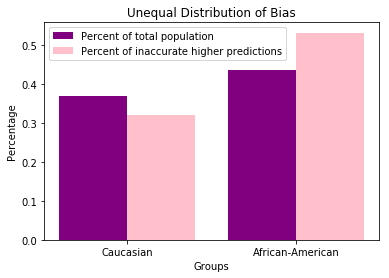

In [481]:
X = test
X["prediction"] = test_predictions
X["actual"] = test_actuals
X["bias"] = X["actual"] < X["prediction"]

worseTotal = X.loc[X["bias"]]
def biasRatio(ethnic_code):
    worsePerRace = len(worseTotal.loc[worseTotal["Ethnic_Code_Text"] == ethnic_code])
    totalPerRace = len(X.loc[X["Ethnic_Code_Text"] == ethnic_code])
    return [totalPerRace/len(X), worsePerRace/len(worseTotal)]

#caucasian, african-american - statistical significance is a .2 difference generally
X_labels = ['Caucasian','African-American']
totalPercent = [biasRatio(0)[0], biasRatio(1)[0]]
biasPercent = [biasRatio(0)[1], biasRatio(1)[1]]
  
X_axis = np.arange(len(X_labels))
  
plt.bar(X_axis - 0.2, totalPercent, 0.4, color='purple', label = 'Percent of total population') 
plt.bar(X_axis + 0.2, biasPercent, 0.4, color='pink', label = 'Percent of inaccurate higher predictions')
  
plt.xticks(X_axis, X_labels)
plt.xlabel("Groups")
plt.ylabel("Percentage")
plt.title("Unequal Distribution of Bias")
plt.legend()
plt.show()

In [461]:
totalPercent

[0.36818742293464857, 0.43600493218249076]

In [462]:
biasPercent

[0.21782178217821782, 0.5841584158415841]

In [467]:
(biasPercent[0] - totalPercent[0])/totalPercent[0]

-0.4083942888595624

In [476]:
def results(target): #for 0, 1, or 2
    results = []
    for x in range(0, len(test)):
        if test_predictions[x] == test_actuals[x] and test_actuals[x] == target:
            results.append("true positive")
        else:
            if test_predictions[x] != test_actuals[x]:
                if test_predictions[x] == target:
                    results.append("false positive")
                elif test_actuals[x] == target:
                    results.append("false negative")
                else:
                    results.append("true negative")
            else:
                results.append("true negative")
    return results

def parities(target, ethnic_code, parity): #target to call results
    test["results"] = results(target)
    falsePositives = test.loc[test["results"] == "false positive"]
    truePositives = test.loc[test["results"] == "true positive"]
    trueNegatives = test.loc[test["results"] == "true negative"]
    
    positives = pd.concat([falsePositives, truePositives])    
    
    total = len(test[test["Ethnic_Code_Text"] == ethnic_code])
    
    if parity == "proportional":
        withinParity = len(positives[positives["Ethnic_Code_Text"] == ethnic_code])
        return withinParity/total #proportion of people who are low, high out of total # in ethnicity
    elif parity == "specificity":
        withinParity = len(trueNegatives[trueNegatives["Ethnic_Code_Text"] == ethnic_code])
        return withinParity/total #proportion of people who are low, high out of total # in ethnicity
    else: 
        #precision = true positives/all positives
        return len(positives[positives["Ethnic_Code_Text"] == ethnic_code])/len(truePositives[truePositives["Ethnic_Code_Text"] == ethnic_code])
        

def graphParities(parity):
    X = ['Low Risk','High Risk']
    X_axis = np.arange(len(X))
    if parity == "proportional":
        black = [parities(0, 1, "proportional"), parities(1, 1, "proportional")]
        white = [parities(0, 0, "proportional"), parities(1, 0, "proportional")]

        plt.title("Proportional Parity")
    elif parity == "specificity":
        black = [parities(0, 1, "specificity"), parities(1, 1, "specificity")]
        white = [parities(0, 0, "specificity"), parities(1, 0, "specificity")]

        plt.title("Specificity Parity")
    else:
        black = [parities(0, 1, "predictive"), parities(1, 1, "predictive")]
        white = [parities(0, 0, "predictive"), parities(1, 0, "predictive")]

        plt.title("Predictive Parity")

    plt.bar(X_axis - 0.2, white, 0.4, color='green', label = 'Caucasian') 
    plt.bar(X_axis + 0.2, black, 0.4, color='blue', label = 'African-American')

    plt.xticks(X_axis, X)
    plt.xlabel("Risk Levels")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()
    

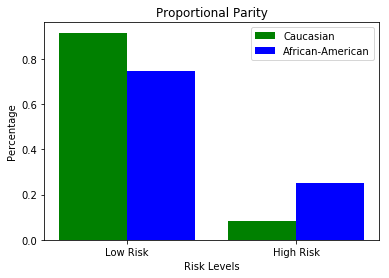

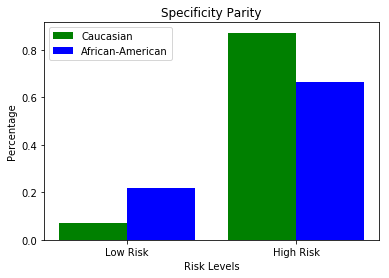

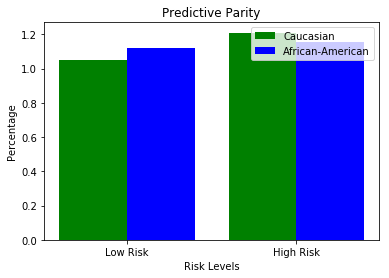

In [477]:
graphParities("proportional") #much more willing to predict high risk for black people
graphParities("specificity") #more willing to be true negative for white people at high risk
graphParities("predictive")

# Regularization

In [413]:
#how to remove bias here?
s = 2 #sensitive_index

y = np.array([0,1])
w = clf.coef_[0]
x = test.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 9]].values
#x downtack w is x transpose time w matrix, the parameter of each of sigmoid functions that we sum

x_t = np.transpose(x)
x_tw = np.matmul(w, x_t) #a

In [414]:
sigsum(x_tw).shape

(4055,)

In [415]:
list(test[features.columns[s]].value_counts().keys())

[1, 0, 2, 3, 4, 6, 8, 7]

In [417]:
#test[features.columns[s]].value_counts()[1] #total number of pop
#test.loc[test["binaryScore"] == 1].loc[test[features.columns[s]] == 1].shape[0] #total number of high

#probability that each race gets each prediction is total number of that pop, total number of that prediction
def pr_dict():
    prs = {}
    for x in list(test[features.columns[s]].value_counts().keys()):
        denom = test[features.columns[s]].value_counts()[x]
        high_num = test.loc[test["binaryScore"] == 1].loc[test[features.columns[s]] == x].shape[0]
        low_num = test.loc[test["binaryScore"] == 0].loc[test[features.columns[s]] == x].shape[0]
        prs[x] = [low_num/denom, high_num/denom]
    return prs

In [418]:
prs = pr_dict()
del prs[7]
del prs[8]
prs #only 1 value in 7, 8

{1: [0.6996606334841629, 0.3003393665158371],
 0: [0.8868050904219692, 0.11319490957803081],
 2: [0.8886925795053003, 0.11130742049469965],
 3: [0.8959537572254336, 0.10404624277456648],
 4: [0.967741935483871, 0.03225806451612903],
 6: [0.7368421052631579, 0.2631578947368421]}

In [419]:
prs[test[features.columns[s]][28536]]

[0.6996606334841629, 0.3003393665158371]

In [420]:
test["binaryScore"].value_counts()

0    3267
1     788
Name: binaryScore, dtype: int64

In [421]:
def pr(pr_dict):
    total = test["binaryScore"].shape[0]
    high_tot = test["binaryScore"].value_counts()[1]
    low_tot = test["binaryScore"].value_counts()[0]
    pr_y = []
    for person in test[features.columns[s]]:
        pr_dict[person] #iterate over y's?
        

In [422]:
(test[features.columns[s]].shape, len(sigsum(x_tw))) #traverse thru test is same as traversing thru sigsum(x_tw)

((4055,), 4055)

In [423]:
pr_dict()

{1: [0.6996606334841629, 0.3003393665158371],
 0: [0.8868050904219692, 0.11319490957803081],
 2: [0.8886925795053003, 0.11130742049469965],
 3: [0.8959537572254336, 0.10404624277456648],
 4: [0.967741935483871, 0.03225806451612903],
 6: [0.7368421052631579, 0.2631578947368421],
 8: [1.0, 0.0],
 7: [0.0, 1.0]}

In [433]:
#each y * the sigmoid of each factor weight + (1-y)(1-the sigmoid of each factor weight) * [ln(pr_y/s) - ln(pr_y)]

#for pr_y
total = test["binaryScore"].shape[0]
high_tot = test["binaryScore"].value_counts()[1]
low_tot = test["binaryScore"].value_counts()[0]
totals = [low_tot, high_tot]
    
def remover_sum(a, y_value): #low is 0, high is 1
    sig = sigsum(a)
        
    m_list = []
    index = 0
    for person in test[features.columns[s]]:
        if person == 7 or person == 8:
            continue
        pr_y_s = prs[person][y_value]
        pr_y = totals[y_value]/total
        
        ln = np.log(pr_y_s/pr_y)
        m = y_value*sig[index] + (1-y_value)*(1-sig[index])
        m_list.append(m*ln)
        index = index + 1
    return m_list

In [435]:
sum(remover_sum(x_tw, 0)) + sum(remover_sum(x_tw, 1)) #actual value of the regularizer

-67.89098042406474